In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from aquarel import load_theme


# Using the Aquarel library with some customization for the plots
theme = load_theme("boxy_dark")
theme.set_color(figure_background_color="#181818",
                plot_background_color="#242424")
theme.set_font(family="monospace", size=9)
theme.apply_transforms()
theme.apply()


df = pd.read_csv("Data/train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [18]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["Survived"])
Y = df["Survived"]
x_train, x_test, y_train, y_test = train_test_split(X, Y, shuffle=True, test_size=0.1, random_state=42)

In [19]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin


# A custom transformer to make all the extra features
class FeatureEngineering(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.age_bins = [0, 3, 12, 20, 60, 200]
        self.age_labels = ["toddler", "child", "teen", "adult", "senior"]
        self.fare_labels = ["VeryLow", "Low", "Medium", "High"]
                
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # Extracting the title
        X["Title"] = X["Name"].apply(lambda x: x.split(", ")[1].split(".")[0])
        # Grouping the titles
        X["Title"] = X["Title"].apply(lambda x: x if x in ["Mr", "Miss", "Mrs", "Master"] else "Rare")
        X["IsTitleRare"] = X["Title"].apply(lambda x: 1 if x=="Rare" else 0)
        
        # Defining a new feature - age group
        X["Age"].fillna(X["Age"].median(), inplace=True)
        X["AgeGroup"] = pd.cut(X["Age"], bins=self.age_bins, labels=self.age_labels)
        
        # Person + family members on board
        X["FamilySize"] = X["SibSp"] + X["Parch"] + 1
        
        # Calculate adjusted fare (ticket price per person)
        X["Fare"].fillna(X["Fare"].median(), inplace=True)
        X["TicketCount"] = X["Ticket"].map(X["Ticket"].value_counts())
        X["AdjustedFare"] = round(X["Fare"] / X["TicketCount"], 4)
        
        # Replacing Fares = 0 with median and adding log fare
        X["AdjustedFare"].replace(0, X["AdjustedFare"].median(), inplace=True)
        X["LogFare"] = np.log(X['AdjustedFare'])
        
        # Extracting wealth from fare
        self.q25, self.q50, self.q75 = list(X['AdjustedFare'].quantile([.25, .5, .75]))
        self.fare_bins = [0, self.q25, self.q50, self.q75, X["AdjustedFare"].max()]
        X["Wealth"] = pd.cut(X["AdjustedFare"], bins=self.fare_bins, labels=self.fare_labels)
        
        # Extracting deck of residance for each passanger
        X["Deck"] = X["Cabin"].str[0]
        X["Deck"] = X["Deck"].fillna("N/A")
        
        # Check if passenger has cabin
        X["HasCabin"] = X["Deck"].apply(lambda x: 0 if x=="N/A" else 1)
        
        # Check if passenger is traveling solo
        X["IsAlone"] = X["FamilySize"].apply(lambda x: 1 if x==1 else 0)

        return X

In [20]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


num_features = ['Age', 'LogFare', 'FamilySize']
cat_features = ['Pclass', 'Sex', 'Embarked', 'Title', 'Deck', 'AgeGroup', 'Wealth']
drop_features = ['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Fare', 'AdjustedFare', 'Cabin']

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# The all-in-one preprocessing pipeline
preprocessing = Pipeline([
    ('feature_engineering', FeatureEngineering()),
    ('preprocessor', ColumnTransformer([
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features),
        ('dropper', 'drop', drop_features)
    ]))
])

In [21]:
# Hide the unnecessary warning
import warnings
warnings.filterwarnings('ignore')

x_train_preproc = preprocessing.fit_transform(x_train)
x_train_preproc

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 8010 stored elements and shape (801, 34)>

In [22]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from aquarel import load_theme
import json


# Dictionary to store all the cross validation and training data for the models
history = {}

def plot_learning_curves(models_list: list, x, y, cv=5, size:int=10, n_columns:int=3):
    n_models = len(models_list)
    # Calculate the minimum number of rows to fit the plotting grid
    n_rows = (n_models + n_columns - 1) // n_columns

    fig, axs = plt.subplots(nrows=n_rows, ncols=n_columns, figsize=(15, n_rows * 5))
    # Converting the axs objects to a n by m shape, so individual axs would be iterable
    axs = np.array(axs).reshape(n_rows, n_columns)

    for i, (model, model_name) in enumerate(models_list):
        
        try:
            print(f"Working on {model_name}")
            # Evaluating the models performance for multiple cuts of dataset with different sizes
            train_sizes, train_scores, test_scores = learning_curve(
                estimator=model,
                X=x,
                y=y,
                train_sizes=np.linspace(0.1, 1.0, size),
                cv=cv,
                scoring='accuracy'
            );
        except:
            print(f"X is sparse. Converting x to array for {model_name}")
            # Evaluating the models performance for multiple cuts of dataset with different sizes
            train_sizes, train_scores, test_scores = learning_curve(
                estimator=model,
                X=x.toarray(),
                y=y,
                train_sizes=np.linspace(0.1, 1.0, size),
                cv=cv,
                scoring='accuracy'
            );
        
        # Adding the models performance data into a dictionary
        history.update({model_name:[train_sizes.tolist(), train_scores.tolist(), test_scores.tolist()]})

        # One-liner to calculate divizable and remainder, corresponding to row and column of the respected ax
        row, col = divmod(i, n_columns)
        ax = axs[row, col]
        ax.plot(train_sizes, train_scores.mean(axis=1), label="Train", marker="o")
        ax.plot(train_sizes, test_scores.mean(axis=1), label="Valid", marker="s")
        ax.set_title(model_name)
        ax.legend()
    
    fig.supxlabel("Samples in training set")
    fig.supylabel("Accuracy")

    # Remove the remainder empty subplots
    for i in range(n_models, n_rows * n_columns):
        fig.delaxes(axs.flatten()[i])
    
    # Storing all the training and validation performance as a json file    
    with open('history.json', 'w') as file:
        json.dump(history, file)

    plt.tight_layout()
    plt.show()

In [23]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# List of models be plotted and evaluated
models_list = [
    (LogisticRegression(), "LogisticRegression"),
    (SGDClassifier(), "SGDClassifier"),
    (SVC(), "SVC"),
    (DecisionTreeClassifier(), "DecisionTreeClassifier"),
    (RandomForestClassifier(), "RandomForestClassifier"),
    (GradientBoostingClassifier(), "GradientBoostingClassifier"),
    (GaussianNB(), "GaussianNB"),
    (KNeighborsClassifier(), "KNeighborsClassifier"),
    (XGBClassifier(), "XGBClassifier")
]

Working on LogisticRegression
Working on SGDClassifier
Working on SVC
Working on DecisionTreeClassifier
Working on RandomForestClassifier
Working on GradientBoostingClassifier
Working on GaussianNB
X is sparse. Converting x to array for GaussianNB
Working on KNeighborsClassifier
Working on XGBClassifier


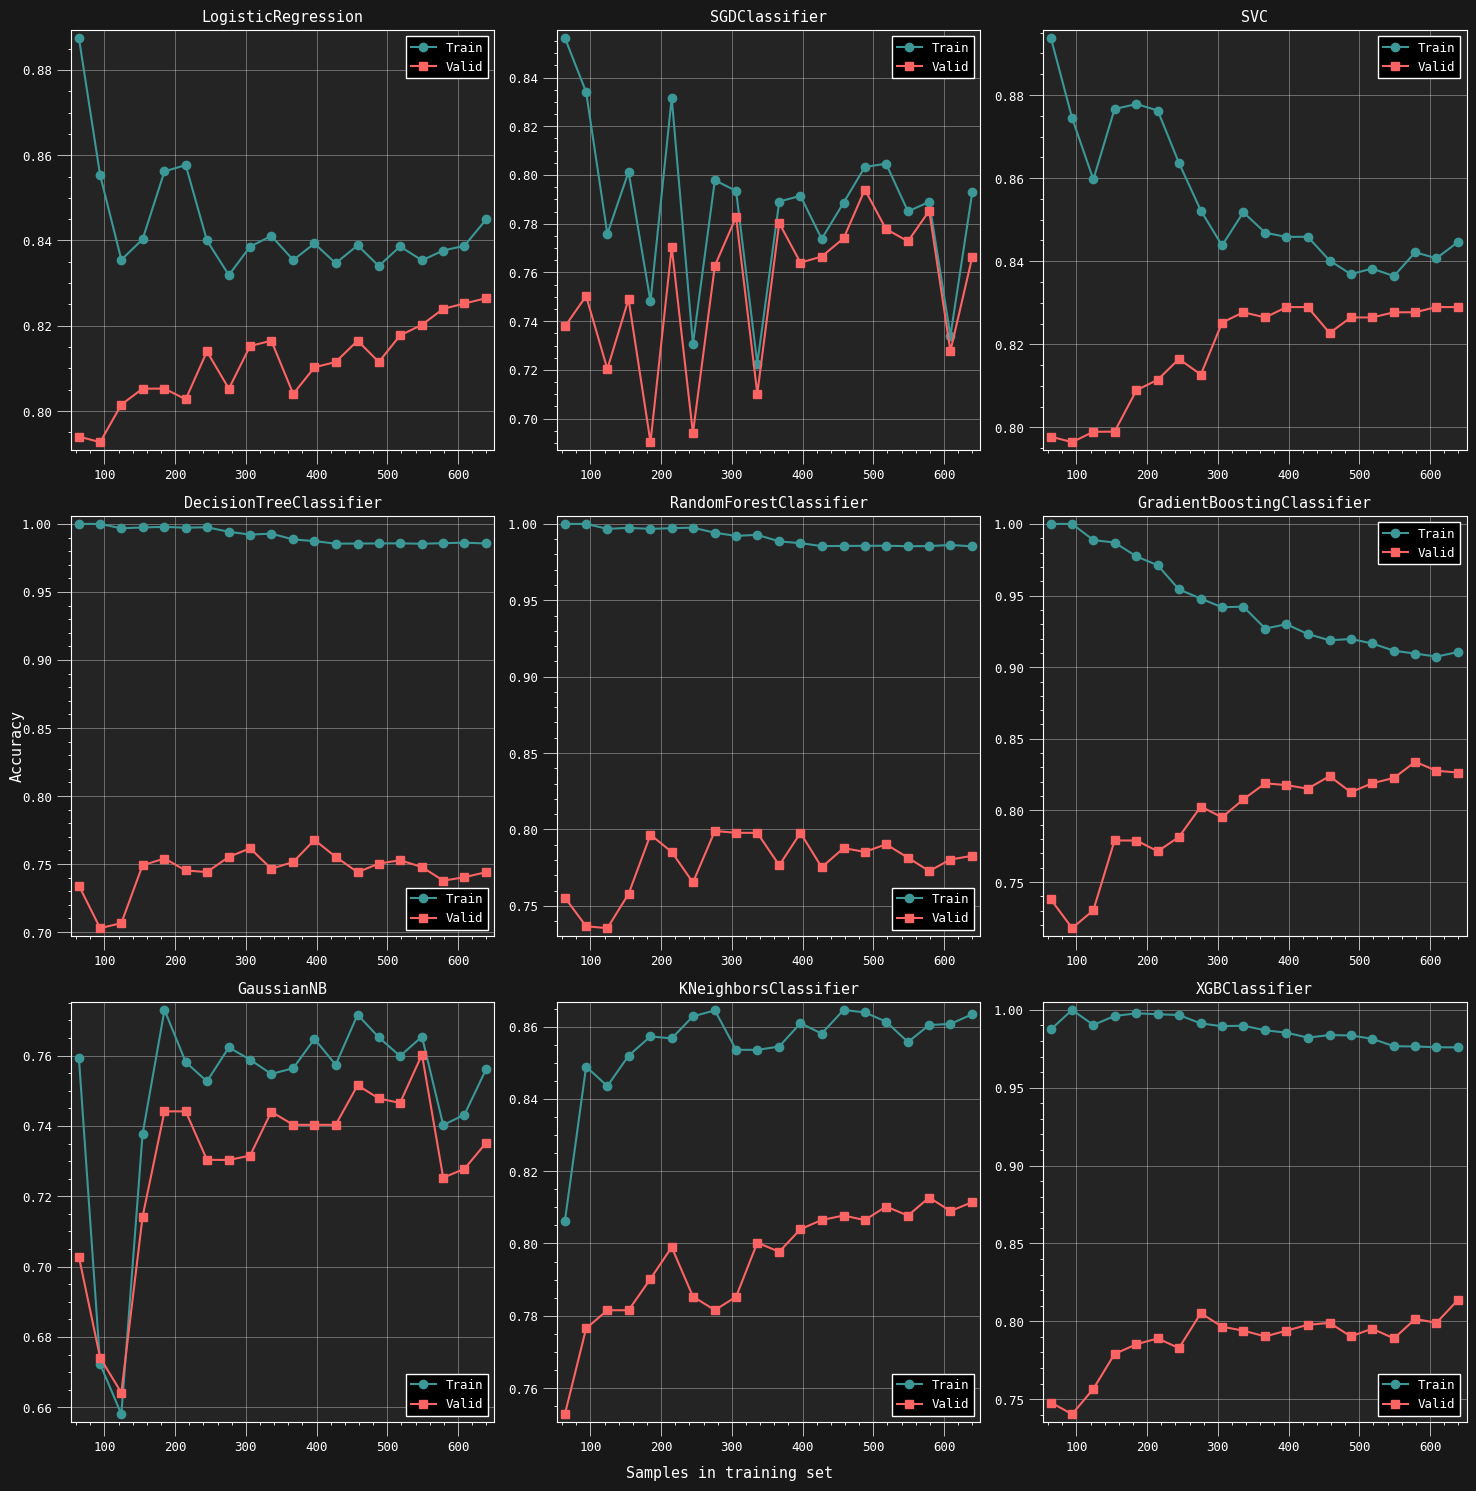

In [24]:
plot_learning_curves(models_list=models_list,
                     x=x_train_preproc,
                     y=y_train,
                     size=20);

In [25]:
from sklearn.model_selection import GridSearchCV


lr_pipeline = make_pipeline(preprocessing, LogisticRegression())

param_dist_lr = {
    'logisticregression__C': np.linspace(1, 100, 20, dtype=int),
}

lr_search = GridSearchCV(
    estimator=lr_pipeline,
    param_grid=param_dist_lr,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

lr_search.fit(x_train, y_train)
lr_search.best_params_

{'logisticregression__C': 1}

In [26]:
svc_pipeline = make_pipeline(preprocessing, SVC())

param_dist_svc = {
    'svc__kernel': ['linear', 'poly', 'rbf'],
    'svc__C': [1, 5, 10, 20],
    'svc__degree': [2, 3, 4, 5],
}

svc_search = GridSearchCV(
    estimator=svc_pipeline,
    param_grid=param_dist_svc,
    cv=3,
    scoring="accuracy",
    n_jobs=-1
)

svc_search.fit(x_train, y_train)
svc_search.best_params_

{'svc__C': 1, 'svc__degree': 2, 'svc__kernel': 'poly'}

In [27]:
rfc_pipeline = make_pipeline(preprocessing, RandomForestClassifier())

param_dist_rfc = {
    'randomforestclassifier__max_depth': [2, 4, 6, 10, 20],
    'randomforestclassifier__max_leaf_nodes': [2, 4, 6, 10, 20],
    'randomforestclassifier__max_features': [2, 4, 6, 10, 20],
    'randomforestclassifier__n_estimators': [50, 100, 200],
}

rfc_search = GridSearchCV(
    estimator=rfc_pipeline,
    param_grid=param_dist_rfc,
    cv=3,
    scoring="accuracy",
    n_jobs=-1
)

rfc_search.fit(x_train, y_train)
rfc_search.best_params_

{'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__max_features': 4,
 'randomforestclassifier__max_leaf_nodes': 20,
 'randomforestclassifier__n_estimators': 50}

In [28]:
knc_pipeline = make_pipeline(preprocessing, KNeighborsClassifier())

param_dist_knc = {
    'kneighborsclassifier__n_neighbors': [3, 5, 7, 9, 11],
    'kneighborsclassifier__leaf_size': np.linspace(10, 100, 10, dtype=int),
}

knc_search = GridSearchCV(
    estimator=knc_pipeline,
    param_grid=param_dist_knc,
    cv=3,
    scoring="accuracy",
    n_jobs=-1
)

knc_search.fit(x_train, y_train)
knc_search.best_params_

{'kneighborsclassifier__leaf_size': 10, 'kneighborsclassifier__n_neighbors': 7}

In [29]:
xgb_pipeline = make_pipeline(preprocessing, XGBClassifier())

param_dist_xgb = {
    'xgbclassifier__learning_rate': [0.01, 0.1, 0.2],
    'xgbclassifier__max_depth': [3, 5, 7],
    'xgbclassifier__subsample': [0.5, 0.7],
    'xgbclassifier__colsample_bytree': [0.5, 0.7],
    'xgbclassifier__n_estimators': [100, 200, 300]
}

xgb_search = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_dist_xgb,
    cv=3,
    scoring="accuracy",
    n_jobs=-1
)

xgb_search.fit(x_train, y_train)
xgb_search.best_params_

{'xgbclassifier__colsample_bytree': 0.5,
 'xgbclassifier__learning_rate': 0.01,
 'xgbclassifier__max_depth': 3,
 'xgbclassifier__n_estimators': 200,
 'xgbclassifier__subsample': 0.7}

Working on LinearRegression-FineTune
Working on SVC-FineTune
Working on RandomForestClassifier-FineTune
Working on KNeighborsClassifier-FineTune
Working on XGBClassifier-FineTune
Working on VotingClassifier-FineTune


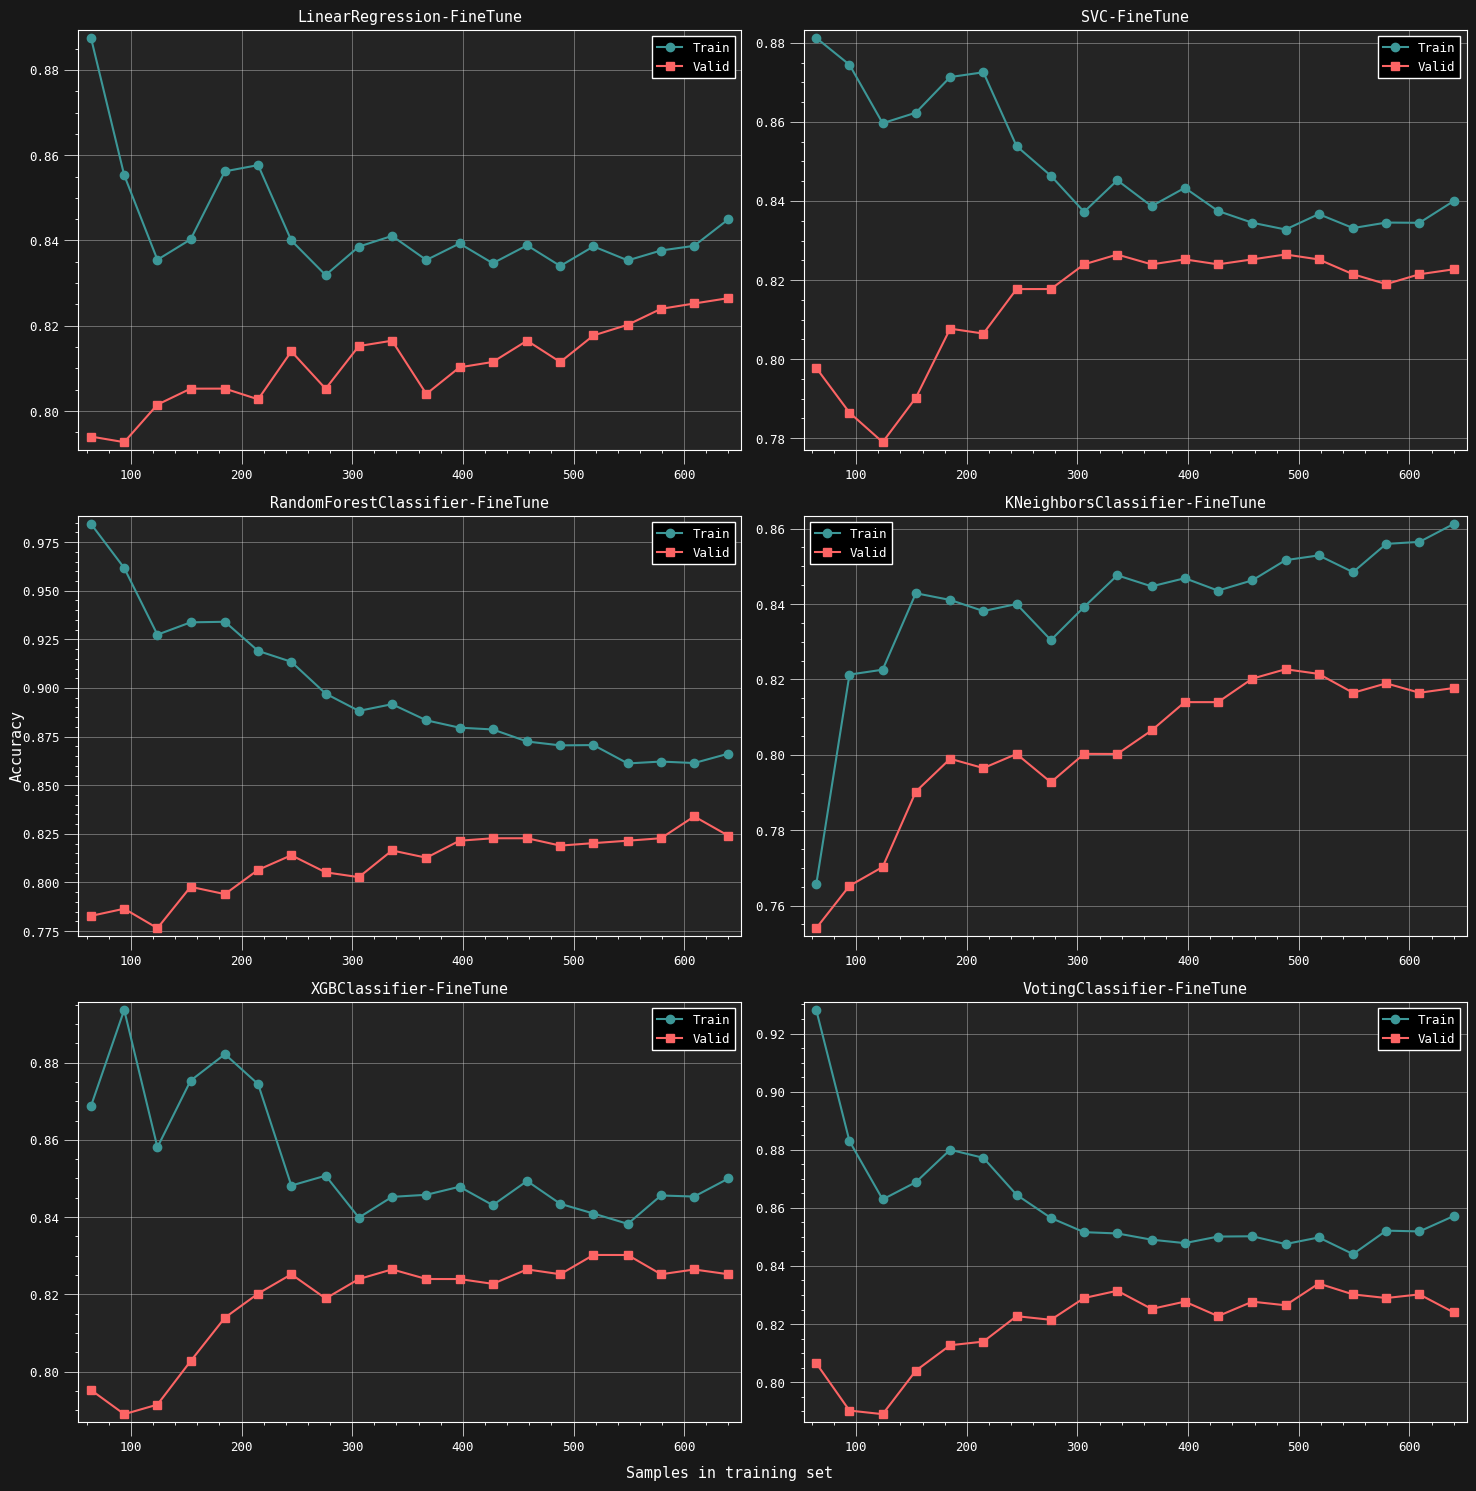

In [30]:
from sklearn.ensemble import VotingClassifier


# Remove prefixes from best_params_
lr_best_params = {k.split("__")[-1]: v for k, v in lr_search.best_params_.items()}
svc_best_params = {k.split("__")[-1]: v for k, v in svc_search.best_params_.items()}
rfc_best_params = {k.split("__")[-1]: v for k, v in rfc_search.best_params_.items()}
knc_best_params = {k.split("__")[-1]: v for k, v in knc_search.best_params_.items()}
xgb_best_params = {k.split("__")[-1]: v for k, v in xgb_search.best_params_.items()}

# Defining the fine-tunned models
lr_model = LogisticRegression(**lr_best_params)
svc_model = SVC(**svc_best_params)
rfc_model = RandomForestClassifier(**rfc_best_params)
knc_model = KNeighborsClassifier(**knc_best_params)
xgb_model = XGBClassifier(**xgb_best_params)

voting_clf_model = VotingClassifier(
    estimators=[
        ('lr', lr_model),
        ('svc', svc_model),
        ('rfc', rfc_model),
        ('knc', knc_model),
        ('xgb', xgb_model),
    ]
)

tunned_models_list = [
    (lr_model, "LinearRegression-FineTune"),
    (svc_model, "SVC-FineTune"),
    (rfc_model, "RandomForestClassifier-FineTune"),
    (knc_model, "KNeighborsClassifier-FineTune"),
    (xgb_model, "XGBClassifier-FineTune"),
    (voting_clf_model, "VotingClassifier-FineTune"),
]

plot_learning_curves(tunned_models_list,
                     x=x_train_preproc,
                     y=y_train,
                     size=20,
                     n_columns=2)

In [31]:
lr_estimator = make_pipeline(preprocessing, lr_model)
svc_estimator = make_pipeline(preprocessing, svc_model)
rfc_estimator = make_pipeline(preprocessing, rfc_model)
knc_estimator = make_pipeline(preprocessing, knc_model)
xgb_estimator = make_pipeline(preprocessing, xgb_model)
voting_clf_estimator = make_pipeline(preprocessing, voting_clf_model)

lr_estimator.fit(x_train,y_train)
svc_estimator.fit(x_train,y_train)
rfc_estimator.fit(x_train,y_train)
knc_estimator.fit(x_train,y_train)
xgb_estimator.fit(x_train,y_train)
voting_clf_estimator.fit(x_train,y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('feature_engineering', FeatureEngineering()),
                                 ('preprocessor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['Age',
                                                                    'LogFare',
                                                                    'FamilySize']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('encode...
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=0.01,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=3,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=200,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=None, ...))]))])

In [32]:
from sklearn.model_selection import cross_val_score

lr_cv_score = cross_val_score(lr_estimator, x_train, y_train, cv=5)
svc_cv_score = cross_val_score(svc_estimator, x_train, y_train, cv=5)
rfc_cv_score = cross_val_score(rfc_estimator, x_train, y_train, cv=5)
knc_cv_score = cross_val_score(knc_estimator, x_train, y_train, cv=5)
xgb_cv_score = cross_val_score(xgb_estimator, x_train, y_train, cv=5)
voting_clf_cv_score = cross_val_score(voting_clf_estimator, x_train, y_train, cv=5)

print(f"Linear Regression Training Set Cross Validation Score: {round(lr_cv_score.mean()*100, 4)} %")
print(f"SVC Training Set Cross Validation Score: {round(svc_cv_score.mean()*100, 4)} %")
print(f"Random Forest Training Set Cross Validation Score: {round(rfc_cv_score.mean()*100, 4)} %")
print(f"K Neighbors Classifier Training Set Cross Validation Score: {round(knc_cv_score.mean()*100, 4)} %")
print(f"XGBoost Classifier Training Set Cross Validation Score: {round(xgb_cv_score.mean()*100, 4)} %")
print(f"Voting Training Set Cross Validation Score: {round(voting_clf_cv_score.mean()*100, 4)} %")

Linear Regression Training Set Cross Validation Score: 81.5217 %
SVC Training Set Cross Validation Score: 82.146 %
Random Forest Training Set Cross Validation Score: 80.3983 %
K Neighbors Classifier Training Set Cross Validation Score: 82.0225 %
XGBoost Classifier Training Set Cross Validation Score: 82.6475 %
Voting Training Set Cross Validation Score: 82.6475 %


In [33]:
print(f"Linear Regression Test Set Score: {round(lr_estimator.score(x_test, y_test)*100, 4)} %")
print(f"SVC Test Set Score: {round(svc_estimator.score(x_test, y_test)*100, 4)} %")
print(f"Random Forest Test Set Score: {round(rfc_estimator.score(x_test, y_test)*100, 4)} %")
print(f"K Neighbors Classifier Test Set Score: {round(knc_estimator.score(x_test, y_test)*100, 4)} %")
print(f"XGBoost Classifier Test Set Score: {round(xgb_estimator.score(x_test, y_test)*100, 4)} %")
print(f"Voting Test Set Score: {round(voting_clf_estimator.score(x_test, y_test)*100, 4)} %")

Linear Regression Test Set Score: 83.3333 %
SVC Test Set Score: 84.4444 %
Random Forest Test Set Score: 81.1111 %
K Neighbors Classifier Test Set Score: 78.8889 %
XGBoost Classifier Test Set Score: 83.3333 %
Voting Test Set Score: 83.3333 %


In [34]:
def predict_to_csv(estimator, data, name):
    
    prediction = estimator.predict(data)
    prediction_df = pd.DataFrame()
    prediction_df['PassengerId'] = data['PassengerId']
    prediction_df['Survived'] = prediction
    prediction_df.to_csv(f"Predictions/{name}_submission.csv", index=False)

In [35]:
test = pd.read_csv("Data/test.csv")

predict_to_csv(lr_estimator, test, "linear-reg")
predict_to_csv(svc_estimator, test, "svc")
predict_to_csv(rfc_estimator, test, "random_forest")
predict_to_csv(knc_estimator, test, "kneighbors")
predict_to_csv(xgb_estimator, test, "xgboost")
predict_to_csv(voting_clf_estimator, test, "voting")